In [16]:
import numpy as np
import pandas as pd
import sidetable
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import sys

In [17]:
sys.path.append(r'c:/Users/hp/kifiya_acadamy_week6/kifiya_week6_assignment/scripts')
df = pd.read_csv('../data/data.csv')
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [18]:
# check target balance (FraudResult)
df.stb.freq(['FraudResult'], style = True)

,FraudResult,count,percent,cumulative_count,cumulative_percent
0,0,"95,469",99.80%,"95,469",99.80%
1,1,193,0.20%,"95,662",100.00%


In [19]:
# check target balance (ProductCategory)
df.stb.freq(['ProductCategory'], style = True)

,ProductCategory,count,percent,cumulative_count,cumulative_percent
0,financial_services,"45,405",47.46%,"45,405",47.46%
1,airtime,"45,027",47.07%,"90,432",94.53%
2,utility_bill,"1,920",2.01%,"92,352",96.54%
3,data_bundles,"1,613",1.69%,"93,965",98.23%
4,tv,"1,279",1.34%,"95,244",99.56%
5,ticket,216,0.23%,"95,460",99.79%
6,movies,175,0.18%,"95,635",99.97%
7,transport,25,0.03%,"95,660",100.00%
8,other,2,0.00%,"95,662",100.00%


In [20]:
# Selecting only numeric variables
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.drop(columns=['CountryCode'])
numeric_df.corr()

,Amount,Value,PricingStrategy,FraudResult
Amount,1.000000,0.989692,-0.061931,0.557370
Value,0.989692,1.000000,-0.017020,0.566739
PricingStrategy,-0.061931,-0.017020,1.000000,-0.033821
FraudResult,0.557370,0.566739,-0.033821,1.000000


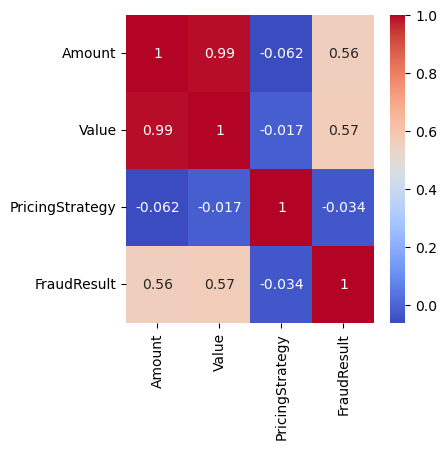

In [47]:
# Create the heatmap
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    numeric_df.corr(),
    cmap='coolwarm',
    annot=True,
    ax=ax
)
# Show the plot
plt.show()

WOE_Transformation

In [22]:
import scorecardpy as sc
from monotonic_binning.monotonic_woe_binning import Binning

In [23]:
# Perform a 70 / 30 split of data
train, test = sc.split_df(df, 'FraudResult', ratio = 0.7, seed = 999).values()

In [24]:
var = train.drop(['FraudResult', 'TransactionId', 'BatchId','AccountId','SubscriptionId','CustomerId','CurrencyCode','CountryCode','ProviderId','ProductId',	'ProductCategory'	,'ChannelId'	,'TransactionStartTime'], axis = 1).columns
y_var = train['FraudResult']

def woe_num(x, y):
  bin_object = Binning(y, n_threshold = 50, y_threshold = 10, p_threshold = 0.35, sign=False)
  global breaks
  breaks = {}
  for i in x:
    bin_object.fit(train[[y, i]])
    breaks[i] = (bin_object.bins[1:-1].tolist())
  return breaks

In [25]:
woe_num(var, 'FraudResult')

{'Amount': [490000.0, 9880000.0],
 'Value': [490000.0, 9880000.0],
 'PricingStrategy': [4.0]}

In [26]:
# Check categorical variables names
bins = sc.woebin(train, y = 'FraudResult', x = [ 'ProductCategory'], save_breaks_list = 'cat_breaks')

[INFO] creating woe binning ...
[INFO] The breaks_list is saved as cat_breaks_20250128_202704.py


Merge numeric and categorical variables breaks

In [27]:
# import dictionary
from cat_breaks_20250128_202704 import breaks_list
breaks_list

# merge
breaks.update(breaks_list)
print(breaks)

{'Amount': [490000.0, 9880000.0], 'Value': [490000.0, 9880000.0], 'PricingStrategy': [4.0], 'ProductCategory': ['data_bundles%,%movies%,%other%,%ticket%,%tv%,%airtime', 'financial_services%,%utility_bill%,%transport']}


Compute WOEs

In [29]:
df_d = df.drop(columns=['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'TransactionStartTime'])

In [30]:
bins_adj = sc.woebin(df_d, 'FraudResult', breaks_list= breaks, positive = 'bad|0') # change positive to adjust WOE to ln(GOOD / BAD)

[INFO] creating woe binning ...


In [40]:
sc.woebin_plot(bins_adj)

{'Amount': <Figure size 640x480 with 2 Axes>,
 'ProductCategory': <Figure size 640x480 with 2 Axes>,
 'Value': <Figure size 640x480 with 2 Axes>,
 'ChannelId': <Figure size 640x480 with 2 Axes>,
 'ProviderId': <Figure size 640x480 with 2 Axes>,
 'PricingStrategy': <Figure size 640x480 with 2 Axes>,
 'ProductId': <Figure size 640x480 with 2 Axes>}

In [37]:
for var, obj in bins_adj.items():
    print(f"{var}: {type(obj)}")

Amount: <class 'pandas.core.frame.DataFrame'>
ProductCategory: <class 'pandas.core.frame.DataFrame'>
Value: <class 'pandas.core.frame.DataFrame'>
ChannelId: <class 'pandas.core.frame.DataFrame'>
ProviderId: <class 'pandas.core.frame.DataFrame'>
PricingStrategy: <class 'pandas.core.frame.DataFrame'>
ProductId: <class 'pandas.core.frame.DataFrame'>


In [43]:
for variable, df in bins_adj.items():
    print(f"{variable} DataFrame columns: {df.columns}")
    print(df.head())

Amount DataFrame columns: Index(['variable', 'bin', 'count', 'count_distr', 'good', 'bad', 'badprob', 'woe', 'bin_iv', 'total_iv', 'breaks', 'is_special_values'], dtype='object')
  variable                   bin  count  count_distr  good    bad   badprob       woe    bin_iv  total_iv     breaks  is_special_values
0   Amount       [-inf,490000.0)  95435     0.997627    25  95410  0.999738  2.043187  1.777243  8.073809   490000.0              False
1   Amount  [490000.0,9880000.0)    226     0.002362   167     59  0.261062 -7.244332  6.263935  8.073809  9880000.0              False
2   Amount       [9880000.0,inf)      1     0.000010     1      0  0.000000 -6.309237  0.032631  8.073809        inf              False
ProductCategory DataFrame columns: Index(['variable', 'bin', 'count', 'count_distr', 'good', 'bad', 'badprob', 'woe', 'bin_iv', 'total_iv', 'breaks', 'is_special_values'], dtype='object')
          variable                                                bin  count  count_distr

In [45]:
for variable, df in bins_adj.items():
    plt.figure(figsize=(8, 6))
    plt.bar(df['bin'], df['woe'], color='skyblue')  # Replace 'bin' and 'woe' with actual column names
    plt.xlabel('Bin')
    plt.ylabel('WOE')
    plt.title(f'WOE Plot for {variable}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{variable}_woe_plot.png")  # Save as PNG file
    plt.close()  # Close the figure after saving
